# Proyecto Redes Neuronales: Perceptrón Multicapa con Embeddings (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo MLP con embeddings usando PyTorch (Entrega 1 - refactorización)  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos con PyTorch
3. Tokenización y Vocabulario Personalizado
4. Construcción del Modelo MLP con Embedding en PyTorch
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Visualización de Resultados
8. Guardado de Experimentos

## 0. Configuración de Parámetros Globales

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_PyTorch_Embedding"
MODEL_TYPE = "MLP_Embedding_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_1"

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Configuración del dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"  # None para todos
USE_TITLE_AND_BODY = True

# Parámetros de tokenización y vocabulario
MAX_VOCAB_SIZE = 80000
MAX_LENGTH = 300
OOV_TOKEN = "<OOV>"
PAD_TOKEN = "<PAD>"

# Arquitectura del modelo
EMBEDDING_DIM = 300
HIDDEN_LAYERS = [256, 128, 64]
DROPOUT_RATE = 0.5  

# Parámetros de entrenamiento
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.0005  
PATIENCE = 15  
WEIGHT_DECAY = 0.0001  

print(f"=== Configuración: {EXPERIMENT_NAME} ===")
print(f"Framework: PyTorch")
print(f"Proyecto: {PROJECT_PART}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Embedding: {EMBEDDING_DIM}d")
print(f"Max Length: {MAX_LENGTH}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Dropout: {DROPOUT_RATE} (aumentado para regularización)")
print(f"Learning Rate: {LEARNING_RATE} (reducido para estabilidad)")
print(f"Weight Decay: {WEIGHT_DECAY} (L2 regularization)")
print(f"Patience: {PATIENCE}")
print("="*60)

=== Configuración: MLP_PyTorch_Embedding ===
Framework: PyTorch
Proyecto: project_part_1
Idioma: en
Embedding: 300d
Max Length: 300
Arquitectura: [256, 128, 64]
Dropout: 0.5 (aumentado para regularización)
Learning Rate: 0.0005 (reducido para estabilidad)
Weight Decay: 0.0001 (L2 regularization)
Patience: 15


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers directamente desde sus módulos
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import MLPWithEmbedding
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)
print(f"GPU disponible: {gpu_info['gpu_available']}")
if gpu_info['gpu_available']:
    print(f"GPU: {gpu_info['gpu_names']}")
    print(f"CUDA: {gpu_info['cuda_version']}")

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070
GPU disponible: True
GPU: ['NVIDIA GeForce RTX 5070']
CUDA: 13.0


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Cargar datos
data_loader = DataLoaderTorch(data_dir=DATA_DIR)
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales:")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE and LANGUAGE_COLUMN in train_df.columns:
    print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
    train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    print(f"Filtrados: Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Distribución de clases
print(f"\nDistribución de clases:")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    print(f"  {stars} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales:
Train: 1,200,000, Val: 30,000, Test: 30,000

Filtrando por idioma: en
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento con Embeddings (PyTorch)

In [4]:
# Preprocesar datos con embeddings
print("\nPreprocesando con PyTorch (Embeddings)...")
processed = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer info
train_loader = processed['train_loader']
val_loader = processed['val_loader']
test_loader = processed['test_loader']
num_classes = processed['num_classes']
vocab_size = processed['vocab_size']

print(f"\nVocabulario: {vocab_size}")
print(f"Clases: {num_classes}")
print(f"Max Length: {MAX_LENGTH}")

class_names = [str(i) for i in data_loader.label_encoder.classes_]


Preprocesando con PyTorch (Embeddings)...
Preprocesando datos de texto...
Tamaño del vocabulario real: 49069
Vocab size usado (limitado): 49070
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario: 49070
Clases: 5
Max Length: 300


## 4. Construcción del Modelo PyTorch con Embeddings

In [5]:
# Crear modelo
print("\nCreando modelo PyTorch con Embeddings...")
model = MLPWithEmbedding(
    vocab_size=vocab_size,  
    embedding_dim=EMBEDDING_DIM,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    padding_idx=0,
    use_masked_pooling=False 
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Arquitectura: Embedding({vocab_size} -> {EMBEDDING_DIM}) -> {HIDDEN_LAYERS}")
print(f"Masked pooling: False (igual que TF sin mask_zero)")

# Verificar inicialización de embeddings
emb_min = model.embedding.weight.min().item()
emb_max = model.embedding.weight.max().item()
print(f"Embedding weights range: [{emb_min:.4f}, {emb_max:.4f}] (esperado: [-0.05, 0.05])")



Creando modelo PyTorch con Embeddings...
Parámetros totales: 14,916,914
Parámetros entrenables: 14,916,914
Arquitectura: Embedding(49070 -> 300) -> [256, 128, 64]
Masked pooling: False (igual que TF sin mask_zero)
Embedding weights range: [-0.0500, 0.0500] (esperado: [-0.05, 0.05])


## 5. Configuración de Entrenamiento

In [6]:
# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
# AÑADIDO: weight_decay para regularización L2 (igual que TensorFlow)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE//3
)

print("\nConfiguración:")
print(f"Optimizador: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience={PATIENCE//3})")
print(f"Regularización: Dropout={DROPOUT_RATE} + L2={WEIGHT_DECAY}")


Configuración:
Optimizador: Adam (lr=0.0005, weight_decay=0.0001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
Regularización: Dropout=0.5 + L2=0.0001


## 6. Entrenamiento

In [7]:
# Entrenar
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

print("\nIniciando entrenamiento...")
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    scheduler=scheduler
)

print(f"\nEntrenamiento completado:")
print(f"Épocas: {training_results['epochs_trained']}")
print(f"Tiempo: {training_results['training_time']:.1f}s")
print(f"Mejor Val Acc: {training_results['best_val_accuracy']:.4f}")

# Guardar componentes
model_name = os.path.basename(training_results['model_path']).replace('.pth', '')
save_model_components_torch(
    model_name=model_name,
    model=model,
    vocab=data_loader.vocab,
    label_encoder=data_loader.label_encoder,
    model_dir=MODEL_DIR
)

Usando dispositivo: cuda

Iniciando entrenamiento...

Entrenando MLP_Embedding_Torch_20251128_134645...
Parámetros totales: 14,916,914
Parámetros entrenables: 14,916,914


Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 337.46it/s, loss=0.6670, acc=52.14%]



Epoch 1/50:
  Train Loss: 1.3160, Train Acc: 0.3918
  Val Loss: 1.0718, Val Acc: 0.5214
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 1.0718)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 320.76it/s, loss=0.6119, acc=57.26%]



Epoch 2/50:
  Train Loss: 1.0681, Train Acc: 0.5445
  Val Loss: 1.0033, Val Acc: 0.5726
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 1.0033)


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 335.61it/s, loss=0.6800, acc=58.00%]



Epoch 3/50:
  Train Loss: 1.0220, Train Acc: 0.5684
  Val Loss: 0.9907, Val Acc: 0.5800
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9907)


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 342.90it/s, loss=0.6221, acc=57.90%]



Epoch 4/50:
  Train Loss: 1.0013, Train Acc: 0.5787
  Val Loss: 0.9814, Val Acc: 0.5790
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9814)


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 317.56it/s, loss=0.7039, acc=58.14%]



Epoch 5/50:
  Train Loss: 0.9879, Train Acc: 0.5843
  Val Loss: 0.9816, Val Acc: 0.5814
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 338.47it/s, loss=0.6984, acc=58.32%]



Epoch 6/50:
  Train Loss: 0.9768, Train Acc: 0.5896
  Val Loss: 0.9751, Val Acc: 0.5832
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9751)


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 335.43it/s, loss=0.6184, acc=58.44%]



Epoch 7/50:
  Train Loss: 0.9689, Train Acc: 0.5935
  Val Loss: 0.9705, Val Acc: 0.5844
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9705)


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 333.41it/s, loss=0.5653, acc=58.82%]



Epoch 8/50:
  Train Loss: 0.9608, Train Acc: 0.5986
  Val Loss: 0.9676, Val Acc: 0.5882
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9676)


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 328.61it/s, loss=0.5942, acc=58.82%]



Epoch 9/50:
  Train Loss: 0.9531, Train Acc: 0.5995
  Val Loss: 0.9683, Val Acc: 0.5882
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 334.67it/s, loss=0.6361, acc=59.42%]



Epoch 10/50:
  Train Loss: 0.9446, Train Acc: 0.6040
  Val Loss: 0.9647, Val Acc: 0.5942
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9647)


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 316.88it/s, loss=0.5798, acc=59.06%]



Epoch 11/50:
  Train Loss: 0.9410, Train Acc: 0.6058
  Val Loss: 0.9638, Val Acc: 0.5906
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9638)


Epoch 12/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 357.24it/s, loss=0.6305, acc=58.92%]



Epoch 12/50:
  Train Loss: 0.9343, Train Acc: 0.6071
  Val Loss: 0.9606, Val Acc: 0.5892
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9606)


Epoch 13/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 353.95it/s, loss=0.6677, acc=58.76%]



Epoch 13/50:
  Train Loss: 0.9284, Train Acc: 0.6111
  Val Loss: 0.9636, Val Acc: 0.5876
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 14/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 330.17it/s, loss=0.6073, acc=59.12%]



Epoch 14/50:
  Train Loss: 0.9213, Train Acc: 0.6129
  Val Loss: 0.9601, Val Acc: 0.5912
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9601)


Epoch 15/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 379.71it/s, loss=0.6110, acc=59.08%]



Epoch 15/50:
  Train Loss: 0.9147, Train Acc: 0.6144
  Val Loss: 0.9614, Val Acc: 0.5908
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 16/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 229.77it/s, loss=0.5844, acc=59.40%]



Epoch 16/50:
  Train Loss: 0.9084, Train Acc: 0.6174
  Val Loss: 0.9656, Val Acc: 0.5940
  Learning Rate: 0.000500
  Épocas sin mejora: 2/15


Epoch 17/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 361.61it/s, loss=0.6532, acc=58.56%]



Epoch 17/50:
  Train Loss: 0.9045, Train Acc: 0.6196
  Val Loss: 0.9639, Val Acc: 0.5856
  Learning Rate: 0.000500
  Épocas sin mejora: 3/15


Epoch 18/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 84.57it/s, loss=0.6508, acc=59.36%]



Epoch 18/50:
  Train Loss: 0.8986, Train Acc: 0.6238
  Val Loss: 0.9595, Val Acc: 0.5936
  Learning Rate: 0.000500
  ✓ Mejor modelo guardado (Val Loss: 0.9595)


Epoch 19/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 383.99it/s, loss=0.7152, acc=58.82%]



Epoch 19/50:
  Train Loss: 0.8924, Train Acc: 0.6247
  Val Loss: 0.9636, Val Acc: 0.5882
  Learning Rate: 0.000500
  Épocas sin mejora: 1/15


Epoch 20/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 360.64it/s, loss=0.6138, acc=58.42%]



Epoch 20/50:
  Train Loss: 0.8874, Train Acc: 0.6275
  Val Loss: 0.9773, Val Acc: 0.5842
  Learning Rate: 0.000500
  Épocas sin mejora: 2/15


Epoch 21/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 360.44it/s, loss=0.6339, acc=59.02%]



Epoch 21/50:
  Train Loss: 0.8816, Train Acc: 0.6305
  Val Loss: 0.9759, Val Acc: 0.5902
  Learning Rate: 0.000500
  Épocas sin mejora: 3/15


Epoch 22/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 341.16it/s, loss=0.6495, acc=59.14%]



Epoch 22/50:
  Train Loss: 0.8759, Train Acc: 0.6317
  Val Loss: 0.9715, Val Acc: 0.5914
  Learning Rate: 0.000500
  Épocas sin mejora: 4/15


Epoch 23/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 342.61it/s, loss=0.6048, acc=59.14%]



Epoch 23/50:
  Train Loss: 0.8699, Train Acc: 0.6345
  Val Loss: 0.9767, Val Acc: 0.5914
  Learning Rate: 0.000500
  Épocas sin mejora: 5/15


Epoch 24/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 351.34it/s, loss=0.6361, acc=59.30%]



Epoch 24/50:
  Train Loss: 0.8643, Train Acc: 0.6373
  Val Loss: 0.9688, Val Acc: 0.5930
  Learning Rate: 0.000250
  Épocas sin mejora: 6/15


Epoch 25/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 361.63it/s, loss=0.7711, acc=58.46%]



Epoch 25/50:
  Train Loss: 0.8355, Train Acc: 0.6521
  Val Loss: 0.9879, Val Acc: 0.5846
  Learning Rate: 0.000250
  Épocas sin mejora: 7/15


Epoch 26/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 362.08it/s, loss=0.6608, acc=59.10%]



Epoch 26/50:
  Train Loss: 0.8263, Train Acc: 0.6580
  Val Loss: 0.9959, Val Acc: 0.5910
  Learning Rate: 0.000250
  Épocas sin mejora: 8/15


Epoch 27/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 361.26it/s, loss=0.6418, acc=58.64%]



Epoch 27/50:
  Train Loss: 0.8174, Train Acc: 0.6614
  Val Loss: 0.9993, Val Acc: 0.5864
  Learning Rate: 0.000250
  Épocas sin mejora: 9/15


Epoch 28/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 357.68it/s, loss=0.7313, acc=58.80%]



Epoch 28/50:
  Train Loss: 0.8122, Train Acc: 0.6643
  Val Loss: 1.0133, Val Acc: 0.5880
  Learning Rate: 0.000250
  Épocas sin mejora: 10/15


Epoch 29/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 356.69it/s, loss=0.7113, acc=58.62%]



Epoch 29/50:
  Train Loss: 0.8035, Train Acc: 0.6674
  Val Loss: 1.0182, Val Acc: 0.5862
  Learning Rate: 0.000250
  Épocas sin mejora: 11/15


Epoch 30/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 353.09it/s, loss=0.6953, acc=58.92%]



Epoch 30/50:
  Train Loss: 0.7957, Train Acc: 0.6716
  Val Loss: 1.0230, Val Acc: 0.5892
  Learning Rate: 0.000125
  Épocas sin mejora: 12/15


Epoch 31/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 343.99it/s, loss=0.7075, acc=58.56%]



Epoch 31/50:
  Train Loss: 0.7728, Train Acc: 0.6857
  Val Loss: 1.0300, Val Acc: 0.5856
  Learning Rate: 0.000125
  Épocas sin mejora: 13/15


Epoch 32/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 355.41it/s, loss=0.7027, acc=58.58%]



Epoch 32/50:
  Train Loss: 0.7645, Train Acc: 0.6897
  Val Loss: 1.0377, Val Acc: 0.5858
  Learning Rate: 0.000125
  Épocas sin mejora: 14/15


Epoch 33/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 363.09it/s, loss=0.7272, acc=58.48%]



Epoch 33/50:
  Train Loss: 0.7586, Train Acc: 0.6917
  Val Loss: 1.0449, Val Acc: 0.5848
  Learning Rate: 0.000125
  Épocas sin mejora: 15/15

Early stopping en época 33

Mejor modelo restaurado
Modelo guardado en: models/project_part_1/MLP_Embedding_Torch_20251128_134645.pth

Entrenamiento completado:
Épocas: 33
Tiempo: 92.3s
Mejor Val Acc: 0.5936
Modelo guardado: models/project_part_1/MLP_Embedding_Torch_20251128_134645.pth
Label encoder guardado: models/project_part_1/MLP_Embedding_Torch_20251128_134645_label_encoder.pkl
Componentes guardados en models/project_part_1/


## 7. Visualización

Gráfico de historial de entrenamiento guardado en: output/project_part_1/MLP_Embedding_Torch_training.png


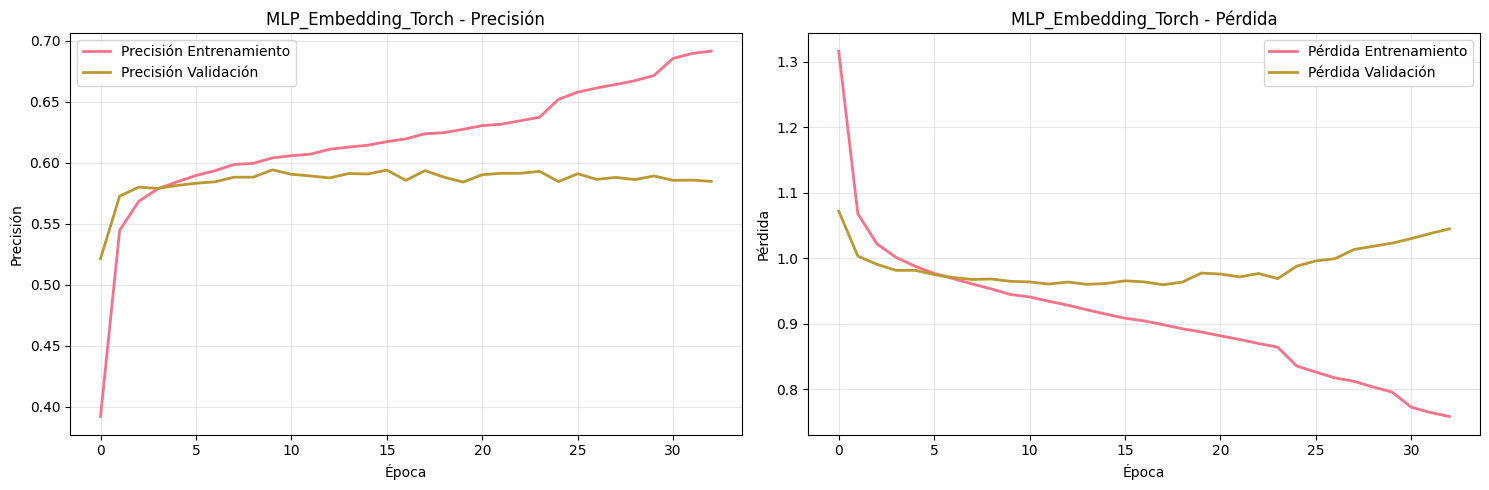

In [8]:
# Visualizar historial
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training.png"),
    framework="pytorch"
)

## 8. Evaluación

In [9]:
# Evaluar
eval_results = evaluate_model_torch(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=trainer.device,
    class_names=class_names
)

test_accuracy = eval_results['test_accuracy']
test_loss = eval_results['test_loss']
y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

classification_rep = classification_report(y_true, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)

print(f"\nResultados:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...
Precisión de Prueba: 0.5886
Pérdida de Prueba: 1.0389

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68      1000
           2       0.50      0.49      0.50      1000
           3       0.47      0.49      0.48      1000
           4       0.58      0.50      0.54      1000
           5       0.72      0.77      0.74      1000

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000


Resultados:
Accuracy: 0.5886
Loss: 1.0389
F1 (macro): 0.5870


## 9. Matriz de Confusión

Matriz de confusión guardada en: output/project_part_1/MLP_Embedding_Torch_confusion.png


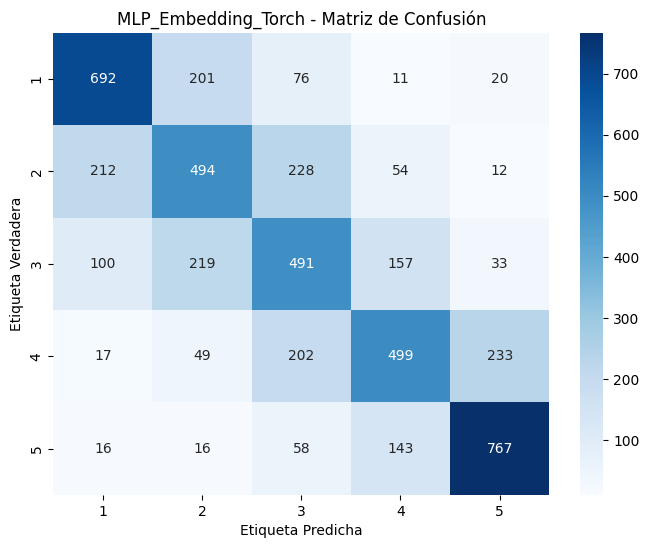

In [10]:
# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion.png")
)

## 10. Guardar Experimento

In [11]:
# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict()
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Proyecto: {PROJECT_PART}")
print(f"Modelo: {training_results['model_path']}")

Experiment 3 results saved to output/project_part_1/experiment_history.json

Experimento #3 guardado
Proyecto: project_part_1
Modelo: models/project_part_1/MLP_Embedding_Torch_20251128_134645.pth


## 11. Resumen

In [12]:
# Resumen
print(f"\n{'='*60}")
print(f"RESUMEN - Experimento #{experiment_id}")
print(f"{'='*60}")
print(f"Framework: PyTorch")
print(f"Modelo: {MODEL_TYPE}")
print(f"Parámetros: {total_params:,}")
print(f"Embedding: {EMBEDDING_DIM}d, Vocab: {vocab_size}")
print(f"\nDatos: Train {len(train_df):,}, Val {len(val_df):,}, Test {len(test_df):,}")
print(f"\nResultados:")
print(f"  Test Acc: {test_accuracy:.4f}")
print(f"  F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"\nHardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")
print(f"{'='*60}")


RESUMEN - Experimento #3
Framework: PyTorch
Modelo: MLP_Embedding_Torch
Parámetros: 14,916,914
Embedding: 300d, Vocab: 49070

Datos: Train 200,000, Val 5,000, Test 5,000

Resultados:
  Test Acc: 0.5886
  F1 (macro): 0.5870

Hardware: GPU


## 12. Historial

In [15]:
# Ver historial
results_mgr.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (3 experimentos)

ID  Modelo          Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP_BoW         en     0.5034     1.7104     11       33.3       200,000   
2   MLP Embedding   en     0.5924     0.9801     34       289.3      200,000   
3   MLP_Embedding_  en     0.5848     1.0449     33       92.3       200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #2 - Accuracy: 0.5924 (200,000 samples)

OVERALL BEST: ID #2 (en) - Accuracy: 0.5924
